# Variability analysis for HBEC IFN experiment

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools


Bad key "text.kerning_factor" on line 4 in
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Get canonical TFs

In [6]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [7]:
# adata_processed = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [8]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [9]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [10]:
adata.shape

(69958, 36588)

### Read 1d HT result comparing to control

In [11]:
cts = [['ciliated'], ['bc', 'basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [12]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read('/data_volume/ifn_hbec/binary_test_deep/{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [13]:
all_result = {}
for ct in cts:
    
    key = '-'.join(ct)
    all_result[key] = {}
    
    all_result[key]['ht'], all_result[key]['moments'] = read_result(ct)

In [14]:
dv_genes = set()
de_genes = set()
all_genes = set()
for ct in cts:
    
    key = '-'.join(ct)    
    df = all_result[key]['ht']
    
    for stim in stims:
        for tp in tps:
            all_genes |= set(all_result[key]['ht'][stim][tp].gene.tolist())
            de_genes |= set(all_result[key]['ht'][stim][tp].query('de_fdr < 0.05').gene.tolist())
            dv_genes |= set(all_result[key]['ht'][stim][tp].query('dv_fdr < 0.1').gene.tolist())

In [15]:
all_result['ciliated']['ht']['beta']['3'].head(5)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
0,LINC01409,0.269090,0.135810,0.047495,0.619429,0.737656,3.365663e-01,0.089426,7.018107e-01
1,NOC2L,0.069103,0.091108,0.448055,-0.156447,0.744702,8.022198e-01,0.556792,9.368110e-01
2,HES4,0.618335,0.050295,0.000008,0.036485,0.148947,8.047195e-01,0.000055,9.375526e-01
3,ISG15,2.725120,0.072049,0.000001,-2.478389,0.170019,3.137984e-35,0.000009,3.025644e-31
4,AGRN,0.897875,0.070454,0.000005,-0.099188,0.332871,7.491251e-01,0.000037,9.155868e-01


###

### Get type-1, 2, 3 ISGs based on upregulation

In [59]:
upreg_beta = set(all_result['ciliated']['ht']['beta']['3'].query('de_fdr < 0.05 & de_coef > 0').gene.tolist())
upreg_alpha = set(all_result['ciliated']['ht']['alpha']['3'].query('de_fdr < 0.05 & de_coef > 0').gene.tolist())
upreg_gamma = set(all_result['ciliated']['ht']['gamma']['3'].query('de_fdr < 0.05 & de_coef > 0').gene.tolist())
upreg_lambda = set(all_result['ciliated']['ht']['lambda']['3'].query('de_fdr < 0.05 & de_coef > 0').gene.tolist())

In [60]:
type1_isg = list((upreg_beta & upreg_alpha))
type2_isg = list(upreg_gamma - (upreg_beta | upreg_alpha))

### Get genes that are likely ISGF3 binding

In [36]:
enc = encode.Encode('/data/home/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [37]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF747ICD/@@download/ENCFF747ICD.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])
stat2_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF204VQS/@@download/ENCFF204VQS.bed.gz',
    'https://www.encodeproject.org/files/ENCFF545JVD/@@download/ENCFF545JVD.bed.gz'
])

In [38]:
intersect_bed = stat1_bed.intersect(stat2_bed).sort()

In [39]:
isgf3_genes = enc.get_peak_genes_bed(intersect_bed, 0).query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 16 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


### Get genes that are likely GAF binding

In [118]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF431NLF/@@download/ENCFF431NLF.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])

In [119]:
potential_gaf_genes = enc\
    .get_peak_genes_encode('https://www.encodeproject.org/files/ENCFF431NLF/@@download/ENCFF431NLF.bed.gz', 0)\
    .query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 16 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


In [120]:
baseline_stat1_genes = enc\
    .get_peak_genes_encode('https://www.encodeproject.org/files/ENCFF323QQU/@@download/ENCFF323QQU.bed.gz', 0)\
    .query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 16 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


In [121]:
gaf_genes =potential_gaf_genes #list(set(potential_gaf_genes) - set(baseline_stat1_genes))

### Gene sets with just moments

In [17]:
mean_long = []
var_long = []

mean, var = all_result['ciliated']['moments']['beta']['3']
mean = mean.rename(columns={'time_step_0':'time_0', 'time_step_1':'time_3'})
var = var.rename(columns={'time_step_0':'time_0', 'time_step_1':'time_3'})

for tp in ['6', '9', '24', '48']:
    m,v = all_result['ciliated']['moments']['beta'][tp]
    ml = m.copy()
    vl = v.copy()
    ml['time'] = tp
    vl['time'] = tp
    ml = m[['gene', 'time_step_1']].rename(columns={'time_step_1':'mean'})
    vl = v[['gene', 'time_step_1']].rename(columns={'time_step_1':'var'})
    m = m[['gene', 'time_step_1']].rename(columns={'time_step_1':'time_'+tp})
    v = v[['gene', 'time_step_1']].rename(columns={'time_step_1':'time_'+tp})
        
#     mean_long.append()
    mean = mean.merge(m, on='gene')
    var = var.merge(v, on='gene')

In [18]:
mean

,gene,time_3,time_0,time_6,time_9,time_24,time_48
0,HES4,1.145554,0.790288,1.375800,1.196331,1.171301,1.073169
1,ISG15,3.390804,1.825076,3.631711,3.039966,2.991579,2.809182
2,AGRN,-0.175982,-0.691860,-0.136874,-0.456595,-0.460011,-0.514530
3,C1orf159,-2.021068,-2.363995,-2.072172,-2.213524,-2.250352,-2.206127
4,AL390719.2,-0.592809,-0.972980,-0.670627,-0.823672,-0.878457,-0.869404
...,...,...,...,...,...,...,...
8330,FUNDC2,-0.903746,-0.631446,-0.842328,-0.644692,-0.671513,-0.601621
8331,CMC4,-1.776921,-1.423289,-1.750980,-1.467767,-1.506587,-1.410784
8332,BRCC3,-1.878570,-1.815602,-1.781647,-1.785017,-1.834553,-1.814033
8333,VBP1,-1.325631,-1.051313,-1.259257,-1.139328,-1.075277,-1.039731


,gene,time_step_1,time_step_0
0,LINC01409,-1.918721,-2.073328
1,NOC2L,-1.137813,-1.177516
2,HES4,1.145554,0.790288
3,ISG15,3.390804,1.825076
4,AGRN,-0.175982,-0.691860
...,...,...,...
9637,FUNDC2,-0.903746,-0.631446
9638,CMC4,-1.776921,-1.423289
9639,BRCC3,-1.878570,-1.815602
9640,VBP1,-1.325631,-1.051313


In [133]:
control_df = mean[['gene', 'time_step_0']].rename(columns={'time_step_0':'mean'}).merge(
var[['gene', 'time_step_0']].rename(columns={'time_step_0':'var'})
)

In [134]:
stim_df = mean.rename(columns={'time_step_1':'mean'}).merge(
var[['gene', 'time_step_1']].rename(columns={'time_step_1':'var'})
)

In [135]:
control_df['type1'] = [g in type1_isg and g in isgf3_genes for g in control_df.gene]
stim_df['type1'] = [g in type1_isg and g in isgf3_genes for g in stim_df.gene]

# control_df['type1'] = [g in type1_isg for g in control_df.gene]
# stim_df['type1'] = [g in type1_isg for g in stim_df.gene]

In [136]:
# upreg_genes = all_result['ciliated']['ht']['beta']['3'].query('de_fdr < 0.1 & de_coef > 0').gene.tolist()

In [137]:
# control_df['isgf3'] = [g in isgf3_genes and g in upreg_genes for g in control_df.gene]
# stim_df['isgf3'] = [g in isgf3_genes and g in upreg_genes for g in stim_df.gene]

# control_df['upreg'] = [g in upreg_genes for g in control_df.gene]
# stim_df['upreg'] = [g in upreg_genes for g in stim_df.gene]

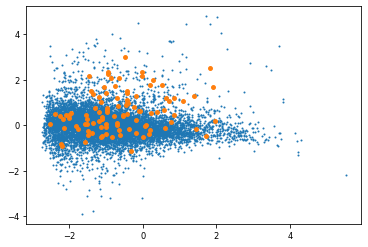

In [138]:
plt.scatter(control_df['mean'],control_df['var'], s=1)
plt.scatter(control_df.query('type1')['mean'],control_df.query('type1')['var'], s=15)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


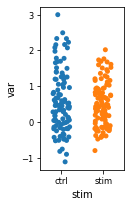

In [139]:
plt.figure(figsize=(1.5, 3))
control_df['stim'] = 'ctrl'
stim_df['stim'] = 'stim'
combined_df = pd.concat([control_df, stim_df])
sns.stripplot(x='stim', y='var', data=combined_df.query('type1'), s=5, jitter=0.2)

(-3, 6)

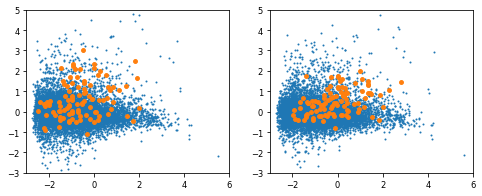

In [140]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)

plt.scatter(control_df['mean'],control_df['var'], s=1)
plt.scatter(control_df.query('type1')['mean'],control_df.query('type1')['var'], s=15)
plt.ylim(-3, 5); plt.xlim(-3, 6)

plt.subplot(1, 2, 2)

plt.scatter(stim_df['mean'],stim_df['var'], s=1)
plt.scatter(stim_df.query('type1')['mean'],stim_df.query('type1')['var'], s=15)
plt.ylim(-3, 5); plt.xlim(-3, 6)


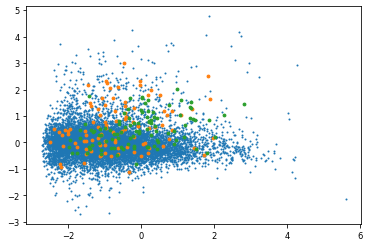

In [142]:
# plt.scatter(control_df['mean'],control_df['var'], s=1)
plt.scatter(stim_df['mean'],stim_df['var'], s=1)

plt.scatter(control_df.query('type1')['mean'],control_df.query('type1')['var'], s=8)

plt.scatter(stim_df.query('type1')['mean'],stim_df.query('type1')['var'], s=8)

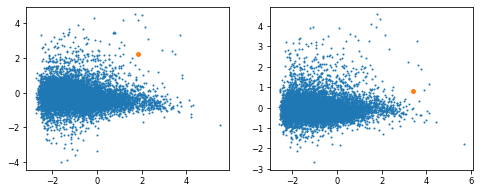

In [147]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)

plt.scatter(control_df['mean'],control_df['var'], s=1)
plt.scatter(control_df.query('gene == "ISG15"')['mean'],control_df.query('gene == "ISG15"')['var'], s=15)

plt.subplot(1, 2, 2)

plt.scatter(stim_df['mean'],stim_df['var'], s=1)
plt.scatter(stim_df.query('gene == "ISG15"')['mean'],stim_df.query('gene == "ISG15"')['var'], s=15)

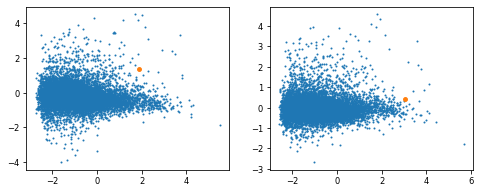

In [154]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)

plt.scatter(control_df['mean'],control_df['var'], s=1)
plt.scatter(control_df.query('gene == "IFI6"')['mean'],control_df.query('gene == "IFI6"')['var'], s=15)

plt.subplot(1, 2, 2)

plt.scatter(stim_df['mean'],stim_df['var'], s=1)
plt.scatter(stim_df.query('gene == "IFI6"')['mean'],stim_df.query('gene == "IFI6"')['var'], s=15)

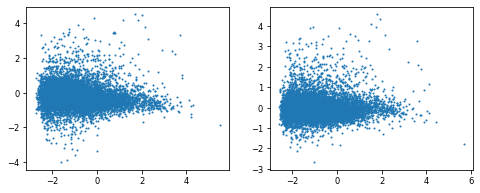

In [155]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)

plt.scatter(control_df['mean'],control_df['var'], s=1)
plt.scatter(control_df.query('gene == "SIGLEC1"')['mean'],control_df.query('gene == "SIGLEC1"')['var'], s=15)

plt.subplot(1, 2, 2)

plt.scatter(stim_df['mean'],stim_df['var'], s=1)
plt.scatter(stim_df.query('gene == "SIGLEC1"')['mean'],stim_df.query('gene == "SIGLEC1"')['var'], s=15)

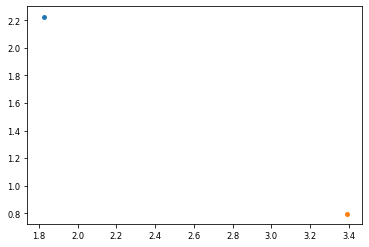

In [148]:
# plt.scatter(control_df['mean'],control_df['var'], s=1)
plt.scatter(control_df.query('gene == "ISG15"')['mean'],control_df.query('gene == "ISG15"')['var'], s=15)

# plt.scatter(stim_df['mean'],stim_df['var'], s=1)
plt.scatter(stim_df.query('gene == "ISG15"')['mean'],stim_df.query('gene == "ISG15"')['var'], s=15)

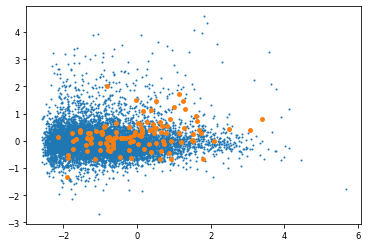

In [143]:
plt.scatter(stim_df['mean'],stim_df['var'], s=1)
plt.scatter(stim_df.query('isgf3')['mean'],stim_df.query('isgf3')['var'], s=15)


In [158]:
control_df.head(5)

,gene,mean,var,isgf3,upreg
0,LINC01409,-2.073328,-0.494383,False,True
1,NOC2L,-1.177516,-0.219102,False,False
2,HES4,0.790288,0.791460,False,True
3,ISG15,1.825076,2.219770,True,True
4,AGRN,-0.691860,0.366197,False,True


In [161]:
for g in stim_df.query('var > 2').gene:
    print(g)

ALPL
STMN1
SFN
MARCKSL1
PDZK1IP1
F3
S100A9
S100A8
NEK2
LINC00342
ANKRD36C
ECRG4
SGO2
CCL20
HES6
FAM3D
TMEM45A
UPK1B
TM4SF1
RARRES1
FGFBP1
CXCL8
CXCL6
CXCL1
CXCL3
CXCL2
EREG
AREG
PLK4
CDC20B
CCNO
SLC26A2
SCGB3A1
IER3
GSTA2
CENPW
AGR2
ANLN
IGFBP3
STEAP4
MUC12
PTN
RARRES2
IDO1
FABP5
FAM83A
LYPD2
SLURP2
CKS2
LRRC26
MSMB
CDK1
DDIT4
PLAU
AL603756.1
MUC5B
TNNT3
CDKN1C
SAA2
SAA1
TCN1
SCGB2A1
SCGB1A1
CDK2AP2
PRSS23
CTSC
POGLUT3
HYLS1
PTHLH
AQP5
KRT7
KRT4
LYZ
TSPAN8
E2F7
ATP12A
CCNA1
CLDN10
RNASE1
DUOXA2
C15orf48
AC023300.2
IL32
VMO1
KRT13
KRT17
SOX9
SERPINB4
SERPINB3
SERPINB2
SERPINB10
AZU1
ICAM1
FCGBP
MIA
CYP2F1
CEACAM6
KLK11
CDC42EP5
BPIFA1
BPIFB1
PI3
BTG3
TFF3


In [160]:
for g in control_df.query('var > 2').gene:
    print(g)

ISG15
ALPL
STMN1
SFN
MARCKSL1
PDZK1IP1
F3
S100A9
NEK2
RSAD2
LINC00342
ANKRD36C
CCL20
SNORC
HES6
FAM3D
TMEM45A
UPK1B
TM4SF1
RARRES1
FGFBP1
CXCL8
CXCL6
CXCL1
CXCL3
CXCL2
EREG
AREG
PLK4
SLC7A11
DDX60L
CDC20B
CCNO
SLC26A2
MIR3142HG
SCGB3A1
HIST1H2BJ
GSTA2
CENPW
MUC12
PTN
RARRES2
IDO1
FABP5
LYPD2
SLURP2
CEP78
LCN2
LRRC26
MSMB
CDK1
PLAU
AL603756.1
IFIT2
IFIT3
HELLS
MUC5B
HBB
SAA4
SAA2
SAA1
TCN1
SCGB1A1
CDK2AP2
CTSC
POGLUT3
HYLS1
PTHLH
AQP5
KRT7
LYZ
TSPAN8
E2F7
OASL
CCNA1
CLDN10
DUOXA2
C15orf48
IL32
VMO1
KRT17
SMIM6
SERPINB3
SERPINB2
AZU1
C3
GDF15
COX7A1
FCGBP
MIA
CYP2F1
CEACAM6
KLK11
CDC42EP5
BPIFA1
BPIFB1
PI3
BTG3
TFF3
LGALS1
